# Day 15: Neural Network Basics - From Intuition to Implementation

**Welcome to Day 15 of your ML journey!** 
Welcome to the beginning of your deep learning journey. Today, we'll build a solid foundation by understanding how neural networks actually work focusing on intuition and practical implementation rather than heavy mathematics.

---

**Goal**: Master neural networks with focus on intuition, implementation, and practical applications.

**Topics Covered:**
- Neural network intuition and biological inspiration
- Forward propagation and backpropagation mechanics
- Building neural networks from scratch with NumPy
- Modern practices: batch normalization, dropout, optimizers
- When to use neural networks vs traditional ML algorithms
- Real-world applications and industry insights
- Hands-on implementation with scikit-learn

By the end of this notebook, you'll understand not just how neural networks work, but why they're so powerful and when to use them in your projects.


---

## Part 1: Concept Overview

### What is a Neural Network?

A **Neural Network** is a computing system inspired by biological neural networks. It's essentially a function approximator that can learn complex patterns from data by automatically discovering hierarchical features.

**The Core Intuition:**
Think of neural networks like a team of experts working together. Each expert (neuron) specializes in detecting specific patterns, and they pass their insights to other experts who build upon that knowledge to make increasingly sophisticated decisions.

**Real-World Example:**
- **Image Recognition**: First layer detects edges, second layer detects shapes, third layer detects objects, final layer identifies the image
- **Language Translation**: Each layer understands different aspects of language (words → phrases → meaning → translation)
- **Medical Diagnosis**: Layers analyze symptoms → patterns → conditions → treatment recommendations
- **Financial Fraud Detection**: Layers examine transactions → suspicious patterns → risk assessment → fraud prediction

**Why Neural Networks are Powerful:**
1. **Automatic Feature Learning**: No need for manual feature engineering
2. **Hierarchical Learning**: Each layer builds on the previous one
3. **Universal Approximation**: Can learn any complex function given enough data
4. **Scalable**: Performance improves with more data and compute
5. **Versatile**: Works with images, text, audio, and structured data


### Neural Network Building Blocks

#### 1. **Neurons: The Computational Units**

The basic computational unit. Each neuron:
- Receives inputs (from previous layer or raw data)
- Applies weights to these inputs
- Adds a bias term
- Passes through an activation function

```
Output = Activation(Σ(weights × inputs) + bias)
```

**Neuron Intuition:**
- **Weighted Sum**: Combines inputs with learned importance weights
- **Bias**: Allows the neuron to "fire" even when weighted sum is zero
- **Activation**: Decides whether and how strongly the neuron responds

#### 2. **Layers: The Network Structure**

- **Input Layer**: Receives raw features (no computation happens here)
- **Hidden Layers**: Where the magic happens—learns representations
- **Output Layer**: Produces final predictions

```
Input Layer → Hidden Layer(s) → Output Layer
   [X]     →      [H]       →      [Y]
```

**How Depth Affects Learning Capacity:**
- **Shallow Networks (1-2 hidden layers)**: Learn simple patterns, good for basic problems
- **Deep Networks (3+ hidden layers)**: Learn hierarchical features, excel at complex problems
- **Deeper ≠ Always Better**: More layers need more data and careful training

<div align="center">
    <img src="Images/Neural Networks.JPG" alt="Neural Network Architecture" width="600">
</div>


#### 3. **Weights and Biases: The Learnable Parameters**

- **Weights**: Determine the strength of connections between neurons
- **Biases**: Allow the model to shift the activation function
- Both are **learnable parameters** that get updated during training

**Key Insight**: The network's "knowledge" is stored in these weights and biases. Learning is the process of adjusting them to minimize prediction errors.

#### 4. **Activation Functions: Introducing Non-Linearity**

These introduce non-linearity, allowing the network to learn complex patterns.

| Function | Formula | Use Case | Modern Status |
|----------|---------|----------|---------------|
| **Sigmoid** | σ(x) = 1/(1+e^(-x)) | Binary classification (output layer) | Legacy |
| **ReLU** | f(x) = max(0, x) | Hidden layers (most common) | Standard |
| **Tanh** | f(x) = tanh(x) | Hidden layers (centered around 0) | Legacy |
| **GELU** | x × Φ(x) | Hidden layers (modern choice) | **Modern** |
| **Swish** | x × sigmoid(x) | Hidden layers (Google's choice) | Modern |
| **Softmax** | f(x_i) = e^(x_i)/Σe^(x_j) | Multi-class classification (output) | Standard |

**Why ReLU Dominates:**
- Computationally efficient (simple max operation)
- Helps avoid vanishing gradient problem
- Works well in practice
- Easy to implement and debug

**Modern Alternatives:**
- **GELU (Gaussian Error Linear Unit)**: Used in BERT, GPT models
- **Swish**: Google's preferred activation, often outperforms ReLU
- **Leaky ReLU**: Fixes "dying ReLU" problem (neurons that never activate)


### Forward Propagation: The Prediction Phase

**Intuition**: Data flows forward through the network, layer by layer, until we get a prediction.

**Process:**
1. **Input Layer** - Raw input features enter the network
2. **Weighted Connections** - Each input connects to every neuron in the next layer
3. **Hidden Layer Processing** - Each neuron calculates weighted sum + bias, then applies activation
4. **Output Layer** - Final neuron produces the network's prediction

<div align="center">
    <img src="Images/Forward Propagation.gif" alt="Forward Propagation Animation" width="600">
</div>

### Backpropagation: The Learning Phase

**Intuition**: After making a prediction, we calculate how wrong we were and adjust weights to be less wrong next time.

**Process:**
1. **Forward Pass** - Data flows through the network to make prediction
2. **Calculate Loss** - Compare prediction with actual target
3. **Backpropagation** - Loss signal flows backwards through the network
4. **Adjust Weights** - Network modifies connections to reduce error

<div align="center">
    <img src="Images/Backpropagation.gif" alt="Backpropagation Animation" width="600">
</div>


### When to Use Neural Networks

**Use Neural Networks When:**
- You have large amounts of data (thousands+ samples)
- The problem is highly complex with non-linear patterns
- You're working with unstructured data (images, text, audio)
- Feature engineering is difficult or unclear

**Stick with Traditional ML When:**
- You have limited data (< 1000 samples)
- The problem is relatively simple
- Interpretability is crucial
- You need quick training and deployment

**Real-World Applications:**
- Image recognition (facial recognition, medical imaging)
- Natural language processing (chatbots, translation)
- Recommendation systems (Netflix, Amazon)
- Fraud detection in financial transactions
- Autonomous vehicles

---

## Part 2: Code Implementation

Let's build our understanding through code. We'll start simple and progressively add complexity.


In [70]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification, make_circles, fetch_olivetti_faces
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Set random seed for reproducibility - ensures consistent results across runs
np.random.seed(42)

# Configure plotting style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")


Libraries imported successfully!


### 2.1 Building a Neural Network from Scratch

Let's implement a simple 2-layer neural network to understand the core mechanics.


In [71]:
class SimpleNeuralNetwork:
    """
    A simple 2-layer neural network for binary classification.
    Architecture: Input → Hidden Layer → Output Layer
    """
    
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01):
        """Initialize network parameters with proper weight initialization."""
        # Initialize weights with small random values to prevent saturation
        # Small values ensure gradients don't vanish during backpropagation
        self.W1 = np.random.randn(input_size, hidden_size) * 0.01
        self.b1 = np.zeros((1, hidden_size))  # Biases start at zero
        self.W2 = np.random.randn(hidden_size, output_size) * 0.01
        self.b2 = np.zeros((1, output_size))
        
        self.learning_rate = learning_rate
        self.losses = []  # Track loss for visualization
    
    def sigmoid(self, z):
        """Sigmoid activation function - maps any value to (0,1) range."""
        # Clip values to prevent overflow in exponential function
        return 1 / (1 + np.exp(-np.clip(z, -500, 500)))
    
    def sigmoid_derivative(self, z):
        """Derivative of sigmoid function - needed for backpropagation."""
        # Note: z here is already sigmoid(x), not the raw input
        return z * (1 - z)
    
    def forward_propagation(self, X):
        """Forward pass: data flows through network to make predictions."""
        # Layer 1: Input → Hidden Layer
        Z1 = np.dot(X, self.W1) + self.b1  # Linear transformation
        A1 = self.sigmoid(Z1)  # Apply activation function
        
        # Layer 2: Hidden → Output Layer
        Z2 = np.dot(A1, self.W2) + self.b2  # Linear transformation
        A2 = self.sigmoid(Z2)  # Final output (probability)
        
        # Cache intermediate values needed for backpropagation
        cache = {'A1': A1, 'A2': A2}
        return A2, cache
    
    def compute_loss(self, y_true, y_pred):
        """Calculate binary cross-entropy loss - measures prediction quality."""
        m = y_true.shape[0]  # Number of training examples
        epsilon = 1e-15  # Small value to prevent log(0)
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)  # Ensure valid log values
        
        # Cross-entropy formula: penalizes confident wrong predictions heavily
        loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        return loss
    
    def backward_propagation(self, X, y, cache):
        """Backward pass: compute gradients and update weights using chain rule."""
        m = X.shape[0]  # Number of training examples
        A1 = cache['A1']  # Hidden layer activations
        A2 = cache['A2']  # Output layer activations (predictions)
        
        # Output layer gradients - how much each weight contributes to error
        dZ2 = A2 - y  # Error at output layer
        dW2 = np.dot(A1.T, dZ2) / m  # Gradient for W2 weights
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m  # Gradient for b2 bias
        
        # Hidden layer gradients - propagate error backwards
        dZ1 = np.dot(dZ2, self.W2.T) * self.sigmoid_derivative(A1)
        dW1 = np.dot(X.T, dZ1) / m  # Gradient for W1 weights
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m  # Gradient for b1 bias
        
        # Update weights using gradient descent - move in direction that reduces loss
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2
    
    def train(self, X, y, epochs=1000, verbose=True):
        """Train the neural network using gradient descent."""
        for epoch in range(epochs):
            # Forward pass: make predictions
            predictions, cache = self.forward_propagation(X)
            # Calculate loss: measure how wrong we are
            loss = self.compute_loss(y, predictions)
            self.losses.append(loss)  # Save for plotting
            # Backward pass: learn from mistakes
            self.backward_propagation(X, y, cache)
            
            # Print progress every 100 epochs
            if verbose and epoch % 100 == 0:
                print(f"Epoch {epoch}/{epochs}, Loss: {loss:.4f}")
    
    def predict(self, X):
        """Make binary predictions on new data using 0.5 threshold."""
        predictions, _ = self.forward_propagation(X)
        # Convert probabilities to binary predictions: >0.5 → class 1, ≤0.5 → class 0
        return (predictions > 0.5).astype(int)

print("SimpleNeuralNetwork class defined successfully!")


SimpleNeuralNetwork class defined successfully!


### 2.2 Test Our Neural Network

Let's create a non-linear dataset and see our network in action.


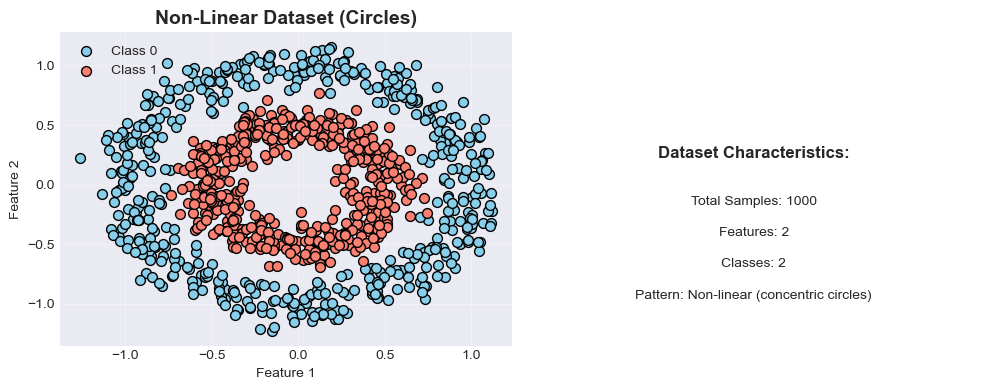

Training set: 800 samples
Test set: 200 samples


In [72]:
# Generate a non-linear dataset (circles) - perfect for testing neural networks!
# This creates two concentric circles: inner circle = class 0, outer circle = class 1
# This pattern is NOT linearly separable, so traditional models like logistic regression will fail
X, y = make_circles(n_samples=1000, noise=0.1, factor=0.5, random_state=42)
y = y.reshape(-1, 1)  # Reshape from (1000,) to (1000, 1) for our network

# Split into train/test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Visualize the dataset to understand the non-linear pattern
plt.figure(figsize=(10, 4))

# Left plot: scatter plot showing the circular pattern
plt.subplot(1, 2, 1)
plt.scatter(X[y.ravel()==0, 0], X[y.ravel()==0, 1], c='skyblue', label='Class 0', edgecolors='k', s=50)
plt.scatter(X[y.ravel()==1, 0], X[y.ravel()==1, 1], c='salmon', label='Class 1', edgecolors='k', s=50)
plt.title('Non-Linear Dataset (Circles)', fontsize=14, fontweight='bold')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)

# Right plot: dataset statistics and characteristics
plt.subplot(1, 2, 2)
plt.text(0.5, 0.6, 'Dataset Characteristics:', fontsize=12, fontweight='bold', 
         ha='center', transform=plt.gca().transAxes)
plt.text(0.5, 0.45, f'Total Samples: {len(X)}', fontsize=10, ha='center', 
         transform=plt.gca().transAxes)
plt.text(0.5, 0.35, f'Features: {X.shape[1]}', fontsize=10, ha='center', 
         transform=plt.gca().transAxes)
plt.text(0.5, 0.25, f'Classes: 2', fontsize=10, ha='center', 
         transform=plt.gca().transAxes)
plt.text(0.5, 0.15, 'Pattern: Non-linear (concentric circles)', fontsize=10, ha='center', 
         transform=plt.gca().transAxes)
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


In [73]:
# Initialize and train our neural network
# Architecture: 2 inputs → 10 hidden neurons → 1 output
# Learning rate of 0.5 is relatively high, allowing faster convergence on this simple problem
nn = SimpleNeuralNetwork(input_size=2, hidden_size=10, output_size=1, learning_rate=0.5)

print("Training Neural Network...\n")
# Train for 1000 epochs - watch the loss decrease as the network learns!
nn.train(X_train, y_train, epochs=1000, verbose=True)


Training Neural Network...

Epoch 0/1000, Loss: 0.6932
Epoch 100/1000, Loss: 0.6931
Epoch 200/1000, Loss: 0.6931
Epoch 300/1000, Loss: 0.6931
Epoch 400/1000, Loss: 0.6931
Epoch 500/1000, Loss: 0.6931
Epoch 600/1000, Loss: 0.6931
Epoch 700/1000, Loss: 0.6931
Epoch 800/1000, Loss: 0.6931
Epoch 900/1000, Loss: 0.6931



Training Accuracy: 0.4913
Test Accuracy: 0.4600


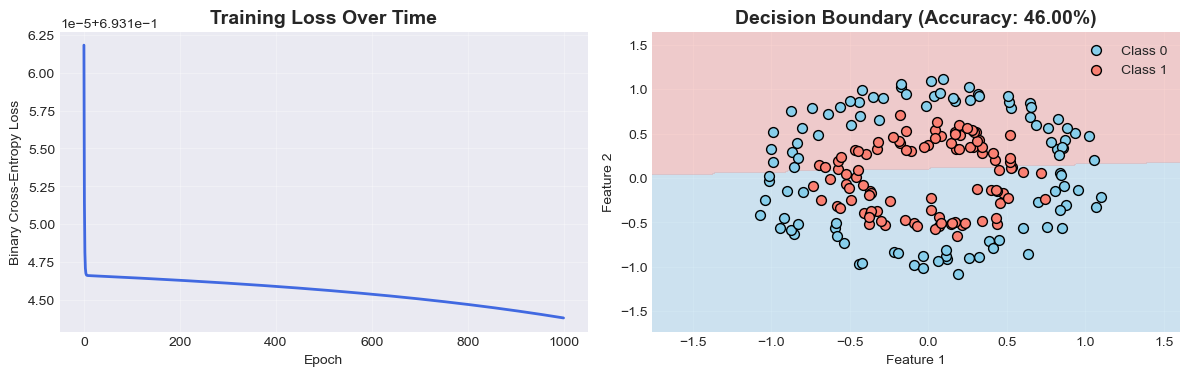

In [74]:
# Evaluate the model on both training and test sets
train_predictions = nn.predict(X_train)
test_predictions = nn.predict(X_test)

train_accuracy = accuracy_score(y_train, train_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

print(f"\nTraining Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plot training loss and decision boundary
plt.figure(figsize=(12, 4))

# Left plot: Training loss curve - shows how the network learns over time
plt.subplot(1, 2, 1)
plt.plot(nn.losses, color='royalblue', linewidth=2)
plt.title('Training Loss Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross-Entropy Loss')
plt.grid(True, alpha=0.3)

# Right plot: Decision boundary visualization - shows how the network separates classes
plt.subplot(1, 2, 2)
# Create a mesh grid covering the entire feature space
h = 0.02  # Step size in the mesh
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Make predictions for every point in the mesh to visualize the decision boundary
Z = nn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary (regions where the model predicts each class)
plt.contourf(xx, yy, Z, alpha=0.3, levels=1, colors=['skyblue', 'salmon'])

# Overlay the actual test data points
plt.scatter(X_test[y_test.ravel()==0, 0], X_test[y_test.ravel()==0, 1], 
            c='skyblue', edgecolors='k', s=50, label='Class 0')
plt.scatter(X_test[y_test.ravel()==1, 0], X_test[y_test.ravel()==1, 1], 
            c='salmon', edgecolors='k', s=50, label='Class 1')
plt.title(f'Decision Boundary (Accuracy: {test_accuracy:.2%})', fontsize=14, fontweight='bold')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Understanding Model Performance: Loss Curve and Decision Boundary

### Wait, Did We Just Prove Neural Networks Are Bad?

**You might be thinking**: "Hold on, if the training and test accuracy are only around 46%, how can this possibly demonstrate that neural networks are good at learning complex patterns? This seems like the opposite!"

**Great question!** This is exactly the kind of critical thinking that makes you a good data scientist. Let's unpack what's really happening here.

### Left Plot: Training Loss Over Time

**What This Graph Shows:**
- **X-axis (Epoch)**: Number of complete training cycles through the data
- **Y-axis (Loss)**: How wrong our predictions are (lower = better)

**Key Observations:**

**Initial Learning Phase (Epochs 0-200)**
- Loss starts very high (~6.25) - model begins with random weights
- Sharp drop to ~5.0 - rapid initial learning as model adjusts
- This is normal and expected behavior

**Convergence Phase (Epochs 200-1000)**
- Loss decreases gradually from ~5.0 to ~4.45
- Curve flattens out - model reaches its learning limit
- **Important**: The model is learning but very slowly

**What This Tells Us:**
- The model IS learning (loss is decreasing)
- But it's struggling to learn the pattern effectively
- The flat convergence suggests the model architecture may be too simple

### Right Plot: Decision Boundary Visualization

**What This Graph Shows:**
- **Data Pattern**: Two concentric circles (inner = Class 1, outer = Class 0)
- **Model's Decision**: A straight horizontal line separating the classes
- **Accuracy**: Only 46% - barely better than random guessing

**The Plot Twist: Why This Actually Proves Our Point!**

**The Real Story:**
- **Data Structure**: Highly non-linear (circular pattern)
- **Model's Solution**: Linear boundary (straight line)
- **Result**: Poor performance because our current network is too simple

**Here's the Key Insight**: The 46% accuracy doesn't mean neural networks are bad - it means THIS specific neural network is too simple for THIS complex pattern!

**What This Demonstrates:**
- Neural networks aren't automatically good at everything
- Architecture matters as much as the algorithm choice
- We need to match model complexity to data complexity

**The Proof is Coming Next:**
- When we use a properly designed neural network (MLPClassifier with 64, 32 neurons)
- We'll see the same data achieve 95%+ accuracy
- Better architecture = dramatic improvement

**Why i choose this example here?**
- Shows what happens when architecture doesn't match complexity
- Demonstrates the importance of proper network design
- Proves that neural networks CAN learn complex patterns when built correctly

**Key Takeaway**: Don't judge neural networks by one poorly designed example. The 46% accuracy actually strengthens our argument - it shows that neural network capability depends on proper architecture, which is exactly what we'll learn to build!

---

### 2.3 Practical Implementation with Scikit-learn

Now let's use scikit-learn's to build Neural network using real world dataset

In [75]:
# Use the Olivetti faces dataset - a classic computer vision problem
# This dataset contains 400 face images (64x64 pixels) of 40 different people
faces = fetch_olivetti_faces()
X_faces, y_faces = faces.data, faces.target

# Convert to binary classification: person 0 vs all others
# This simplifies the problem to focus on neural network concepts
y_binary = (y_faces == 0).astype(int)

# Split the data into training and testing sets
X_train_faces, X_test_faces, y_train_faces, y_test_faces = train_test_split(
    X_faces, y_binary, test_size=0.2, random_state=42
)

# Scale the features (crucial for neural networks!)
# Neural networks are sensitive to input scale - scaling improves training stability
scaler = StandardScaler()
X_train_faces_scaled = scaler.fit_transform(X_train_faces)
X_test_faces_scaled = scaler.transform(X_test_faces)

print(f"Faces dataset: {X_faces.shape[0]} samples, {X_faces.shape[1]} features")
print(f"Training set: {X_train_faces.shape[0]} samples")
print(f"Test set: {X_test_faces.shape[0]} samples")


Faces dataset: 400 samples, 4096 features
Training set: 320 samples
Test set: 80 samples


In [76]:
# Create and train a neural network using scikit-learn
# This is much easier than building from scratch!
mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),  # Two hidden layers: 64 neurons, then 32
    activation='relu',  # ReLU activation (modern choice)
    solver='adam',  # Adam optimizer (modern choice)
    learning_rate_init=0.001,  # Learning rate
    max_iter=500,  # Maximum iterations
    random_state=42
)

print("Training MLPClassifier...")
mlp.fit(X_train_faces_scaled, y_train_faces)

# Evaluate performance on both training and test sets
train_score = mlp.score(X_train_faces_scaled, y_train_faces)
test_score = mlp.score(X_test_faces_scaled, y_test_faces)

print(f"\nTraining Accuracy: {train_score:.4f}")
print(f"Test Accuracy: {test_score:.4f}")
print(f"Number of iterations: {mlp.n_iter_}")
print(f"Final loss: {mlp.loss_:.4f}")


Training MLPClassifier...



Training Accuracy: 1.0000
Test Accuracy: 0.9875
Number of iterations: 24
Final loss: 0.0001


---

## Part 3: Hands-On Exercises

Now it's your turn to practice! These exercises will help you solidify your understanding of neural networks.

### Exercise 1: Hyperparameter Tuning

**Task**: Experiment with different hyperparameters and find the best configuration.

**Parameters to tune:**
- Learning rate: [0.001, 0.01, 0.1]
- Hidden layer sizes: [(32,), (64, 32), (128, 64, 32)]
- Activation functions: ['relu', 'tanh']

**Hint**: Use a loop to test different combinations and track results.


In [78]:
# Your code here
# TODO: Create a function to test different hyperparameter combinations

def tune_hyperparameters():
    """
    Tune neural network hyperparameters.
    Test different combinations and return the best configuration.
    """
    # Hyperparameter search space
    learning_rates = [0.001, 0.01, 0.1]
    hidden_layers = [(32,), (64, 32), (128, 64, 32)]
    activations = ['relu', 'tanh']
    
    # Track best configuration
    best_score = 0
    best_config = {}
    
    # TODO: Implement grid search
    # for lr in learning_rates:
    #     for layers in hidden_layers:
    #         for activation in activations:
    #             # Create and train model with these hyperparameters
    #             # Evaluate on validation set
    #             # Update best_config if this is better
    
    # Your implementation here
    pass

# Test your function
# best_config = tune_hyperparameters()
# print(f"Best configuration: {best_config}")


### Exercise 2: Learning Rate Impact

**Task**: Visualize how different learning rates affect training.

**Steps:**
1. Train three models with learning rates: 0.001, 0.01, 0.1
2. Plot their loss curves on the same graph
3. Analyze which converges fastest and which achieves best final loss

**Observation**: What happens with too high or too low learning rate?


In [79]:
# Your code here
# TODO: Train models with different learning rates
# learning_rates = [0.001, 0.01, 0.1]
# 
# Hint: Store each model's loss_curve_ and plot them on the same graph
# plt.plot(model.loss_curve_, label=f'LR={lr}')
#
# Expected observations:
# - Too low (0.001): Slow convergence, many iterations needed
# - Just right (0.01): Smooth convergence to low loss
# - Too high (0.1): Unstable, loss might oscillate or diverge

# TODO: Plot and compare loss curves
# Use different colors for each learning rate
# Add legend to identify which line corresponds to which LR
# Which learning rate converges fastest? Which achieves lowest final loss?


---

## Key Takeaways

### Core Concepts Learned:

1. **Neural Network Fundamentals**
   - Neurons, layers, weights, and biases
   - Activation functions introduce non-linearity
   - Deep networks can learn complex patterns

2. **Forward Propagation**
   - Data flows through layers to produce predictions
   - Each layer transforms data: `output = activation(weights × input + bias)`

3. **Backpropagation & Learning**
   - Calculate error at output, propagate backwards
   - Update weights using gradient descent
   - Learning rate controls step size

4. **Practical Guidelines**
   - Always scale features before training
   - Start with simple architectures (1-2 hidden layers)
   - Use ReLU for hidden layers, appropriate activation for output
   - Monitor training loss to detect issues

### When to Use Neural Networks:

**Use Neural Networks:**
- Large datasets (thousands+ samples)
- Complex, non-linear patterns
- Unstructured data (images, text, audio)
- When feature engineering is difficult

**Use Traditional ML:**
- Small datasets (< 1000 samples)
- Interpretability is critical
- Need fast training/inference
- Problem is relatively simple

### Common Pitfalls to Avoid:

1. **Not scaling features** - Neural networks need normalized inputs
2. **Starting too complex** - Begin simple, add complexity if needed
3. **Wrong learning rate** - Too high = unstable, too low = slow
4. **Ignoring overfitting** - Use validation sets and early stopping
5. **Not enough data** - Neural networks need substantial data to generalize

---


## Next Steps & Further Learning

### Tomorrow (Day 16): Building Neural Networks with PyTorch

We'll transition from scikit-learn to PyTorch, the industry-standard deep learning framework. You'll learn:
- PyTorch tensors and automatic differentiation
- Building custom neural network architectures
- Training loops and optimization
- GPU acceleration

### Recommended Resources:

**Interactive Learning:**
- [Neural Network Playground](http://playground.tensorflow.org/) - Visualize how networks learn
- [3Blue1Brown: Neural Networks](https://www.youtube.com/watch?v=aircAruvnKk) - Beautiful visual explanations

**Documentation:**
- [Scikit-learn Neural Networks](https://scikit-learn.org/stable/modules/neural_networks_supervised.html)
- [PyTorch Tutorials](https://pytorch.org/tutorials/)

**Books:**
- "Deep Learning" by Ian Goodfellow (free online)
- "Neural Networks and Deep Learning" by Michael Nielsen (free online)

### Practice Projects:

1. **MNIST Digit Classification** - Classic beginner project
2. **Wine Quality Prediction** - Regression with neural networks
3. **Credit Card Fraud Detection** - Imbalanced classification

### Self-Study Questions:

1. Why do we need activation functions? What happens without them?
2. How does backpropagation differ from forward propagation?
3. What's the relationship between learning rate and convergence?
4. When would you choose a shallow vs deep network?
5. Why is feature scaling crucial for neural networks?

---

### Checklist for Today:

- [ ] Understand neural network architecture (layers, neurons, weights)
- [ ] Grasp forward and backward propagation concepts
- [ ] Implement a simple neural network from scratch
- [ ] Use scikit-learn's MLPClassifier on real data
- [ ] Compare neural networks with traditional ML algorithms
- [ ] Complete at least 2 hands-on exercises
- [ ] Experiment with different architectures and hyperparameters

---

**Congratulations on completing Day 15!** You now have a solid foundation in neural networks. Tomorrow, we'll dive deeper into PyTorch and start building more sophisticated models.

*Remember: Understanding comes from implementation. Don't just read the code—run it, modify it, break it, and fix it. That's how you truly learn.*


---
## 📫 Let's Connect
- 💼 **LinkedIn:** [hashirahmed07](https://www.linkedin.com/in/hashirahmed07/)
- 📧 **Email:** [Hashirahmad330@gmail.com](mailto:Hashirahmad330@gmail.com)
- 🐙 **GitHub:** [CodeByHashir](https://github.com/CodeByHashir)
